In [37]:
import pandas as pd
pd.options.display.max_columns = 50
import seaborn as sns

import catboost as cb # Install guide : https://catboost.ai/en/docs/concepts/python-installation
import shap # Install guide : https://shap.readthedocs.io/en/latest/index.html
shap.initjs() # Shap visualization needs initjs to make it works

In [2]:
df = pd.read_csv('../1.LUCAS2018_initial_analysis/LUCAS-SOIL-2018-v2/LUCAS-SOIL-2018.csv')

In [3]:
# Encode -1 for < LOD
df['CaCO3'] = df['CaCO3'].replace("<  LOD",-1).astype(float)
df['OC'] = df['OC'].replace("< LOD",-1).replace("<0.0",0).astype(float)

df['P']=df['P'].replace("< LOD",-1).replace("<0.0",0).astype(float)
df['N']=df['N'].replace("< LOD",-1).replace("<0.0",0).astype(float)
df['K']=df['K'].replace("< LOD",-1).replace("<0.0",0).astype(float)

In [4]:
# Adjust the parameters heere
target = 'CaCO3' # For demonstration purpose only try to predict the CaCO3
list_X = ['pH_CaCl2','pH_H2O','EC','OC','P','N','K','LC0_Desc','LC1_Desc','LU1_Desc']
list_X_cat = ['LC0_Desc','LC1_Desc','LU1_Desc']

In [5]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [6]:
# Taking the necessary columns, remove missing value and reset the inder
df = df[list_X + [target]].copy()
df.dropna(subset=[target],inplace=True)
df.reset_index(inplace=True)

In [7]:
# Convert the categorical to category so the catboost can works properly
for col in list_X_cat :
    df[col] = df[col].astype('category')

In [8]:
# Model learn from the data
model.fit(df[list_X],df[target],cat_features=list_X_cat)
model.set_feature_names(list_X)

Learning rate set to 0.059991
0:	learn: 160.6823025	total: 225ms	remaining: 3m 44s
1:	learn: 157.1353289	total: 288ms	remaining: 2m 23s
2:	learn: 153.8057022	total: 320ms	remaining: 1m 46s
3:	learn: 150.7559500	total: 348ms	remaining: 1m 26s
4:	learn: 147.9518452	total: 378ms	remaining: 1m 15s
5:	learn: 145.5794451	total: 407ms	remaining: 1m 7s
6:	learn: 143.4561636	total: 436ms	remaining: 1m 1s
7:	learn: 141.3601880	total: 486ms	remaining: 1m
8:	learn: 139.5205191	total: 520ms	remaining: 57.3s
9:	learn: 137.7769747	total: 549ms	remaining: 54.3s
10:	learn: 136.2623008	total: 577ms	remaining: 51.9s
11:	learn: 135.2220978	total: 588ms	remaining: 48.4s
12:	learn: 133.9795144	total: 616ms	remaining: 46.8s
13:	learn: 132.9262034	total: 644ms	remaining: 45.3s
14:	learn: 131.9069717	total: 676ms	remaining: 44.4s
15:	learn: 130.8635769	total: 705ms	remaining: 43.4s
16:	learn: 130.0385339	total: 737ms	remaining: 42.6s
17:	learn: 129.3619433	total: 752ms	remaining: 41s
18:	learn: 128.6446992	tot

# Shap Explanation
- It tries to understand the model behaviour, not the data behaviour
- Bad/Inaacurate model -> Misleading Interpretation
- Correlated Features will interfere/negate the effect of each other

# Global Explainer

Explain global pattern

In [9]:
explainer = shap.TreeExplainer(
    model
) # TreeExplainer design specifically for tree based machine learning model like LGBM, XGBoost and CatBoost
shap_values = explainer(df[list_X])

## Summary Plot
Explain what is the effect of a feature to the prediction when the feature value is high or low

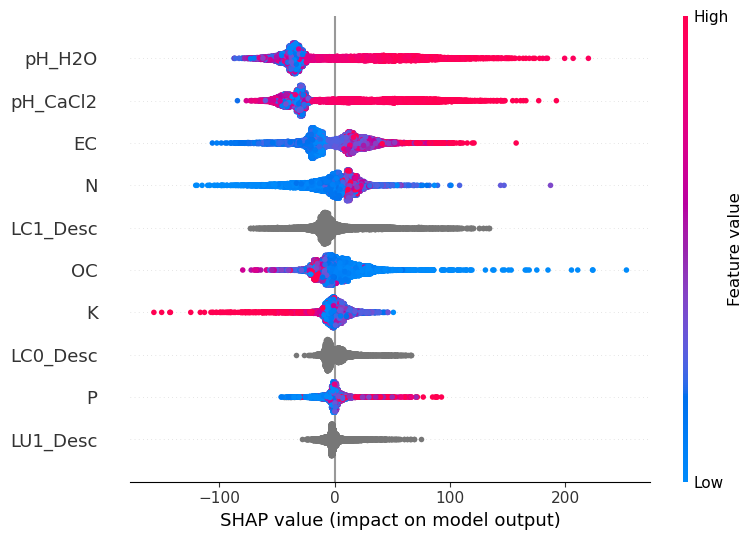

In [10]:
shap.summary_plot(shap_values, feature_names=list_X)

## Heatmap Plot
Convey the same information with the summary plot but in different format

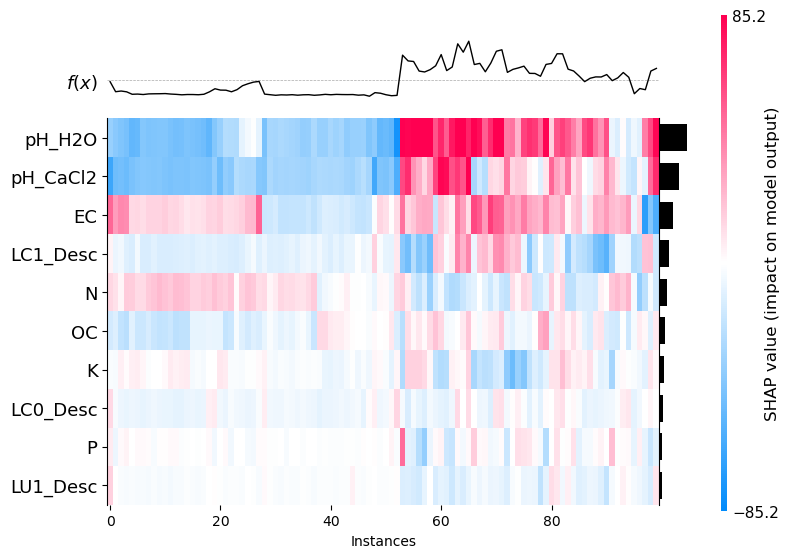

In [18]:
shap.plots.heatmap(shap_values[:100,])
# How to read : The f(x) indicate the prediction. We can see the first 50 row have low prediction value.
# The value of pH_H2O and pH_CaCl2 is the the main factor that decrease the prediction (we don't know whether the predictor have high/low value, but it gives negative impact)

# See the bar on the rightmost side? That's the feature importance. I suspect they calculate it by taking the sum/average of the absolute contribution. 
# So we can say that pH have huge influence in the model and LU1+Desc have low influence.

## SHAP Force Plot
Similar info with the 2 plots above, but in less readble format. I don't encourage using this plot.

In [11]:
shap.plots.force(shap_values[0:100,...], feature_names=list_X)

## Partial Dependence Plot

Explain the effect on one predictor to the prediction

Left Plot : when the pH_CaCl2 < 7, generally it make the prediction lower(because the shap is below 0), but when the pH_CaCl2>7, it give higher prediction

Middle Plot : Left plot with more information. Let me ask a question, if the pH_CaCL2 is low, does that mean the prediction must be small ? Not necessarily because there are still other factors. The color indicates the "total shap" of all other factor considered, so its possible for low pH_CaCl2 environment to have high prediction of CaCO3 because of other factors

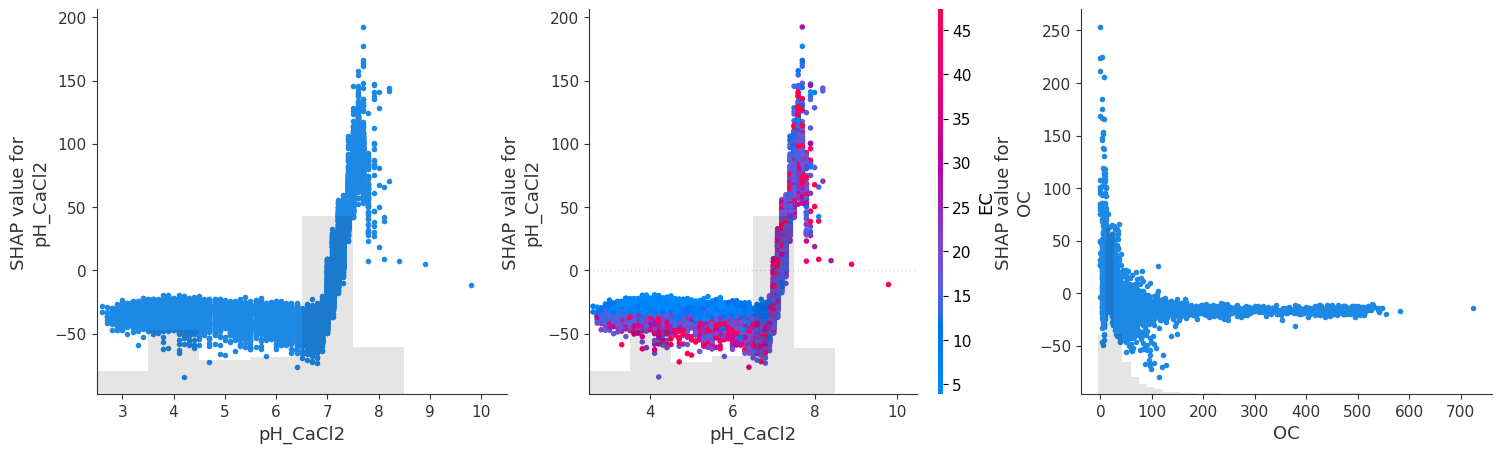

In [38]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,3,figsize=(18,5))
shap.plots.scatter(shap_values[:,'pH_CaCl2'],ax=ax[0],show=False)
shap.plots.scatter(shap_values[:,'pH_CaCl2'],ax=ax[1], color=shap_values,show=False)
shap.plots.scatter(shap_values[:,'OC'],ax=ax[2],show=False);

<Axes: >

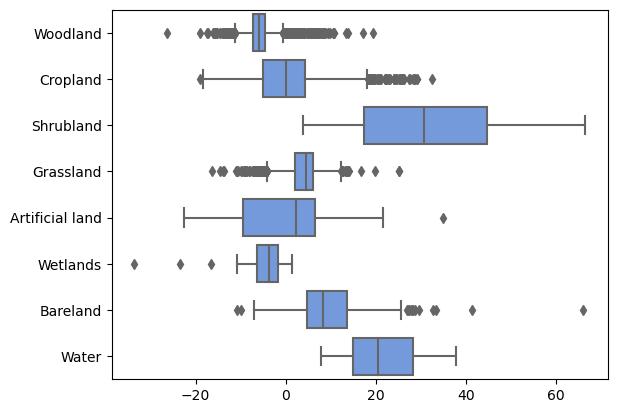

In [40]:
# For some reason the feature dependence plot(PDP) doesn't work with the latest shap, so i just produce the PDP plot using seaborn
cat_feature = 'LC0_Desc'
y_val = shap_values[:,cat_feature].values
x_val = shap_values[:,cat_feature].data

sns.boxplot(y=x_val,x=y_val,color='cornflowerblue')

# Interpretation : If the land is a Shrubland, it will create higher prediction of CaCO3

# Local Explainer
Explain single instance of prediction

## Low CaCO3

In [116]:
df[list_X + [target]].iloc[[0]]

,pH_CaCl2,pH_H2O,EC,OC,P,N,K,LC0_Desc,LC1_Desc,LU1_Desc,CaCO3
0,4.1,4.81,8.73,12.4,-1.0,1.1,101.9,Woodland,Other coniferous woodland,Forestry,3.0


In [117]:
model.predict(df[list_X])[0]

0.485812180962057

In [119]:
shap.plots.force(shap_values[0,...], feature_names=list_X) # Low CaCO3

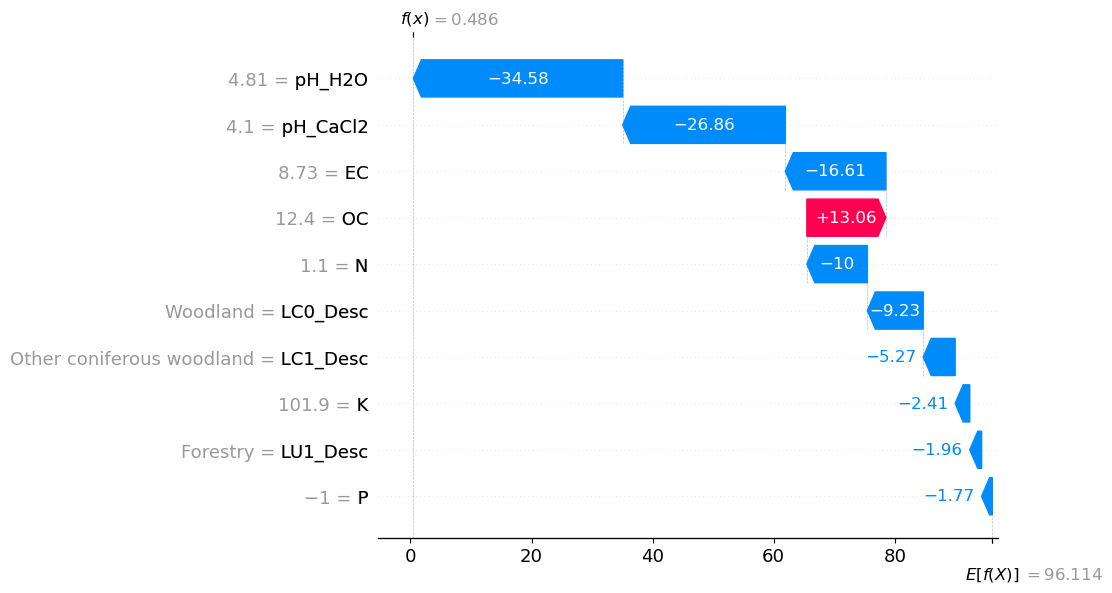

In [126]:
shap.plots.waterfall(shap_values[0,...]) # Low CaCO3

# Medium CaCO3

In [99]:
df[list_X + [target]].iloc[[20]]

,pH_CaCl2,pH_H2O,EC,OC,P,N,K,LC0_Desc,LC1_Desc,LU1_Desc,CaCO3
20,7.0,7.18,39.2,162.9,11.2,5.7,89.5,Woodland,Spruce dominated mixed woodland,Forestry,90.0


In [100]:
model.predict(df[list_X])[[20]]

array([108.50707118])

In [133]:
# shap.plots.force(xgb_explainer.expected_value,shap_values[0,...], feature_names=list_X) # Low CaCO3
shap.plots.force(shap_values[20,...], feature_names=list_X) # Low CaCO3

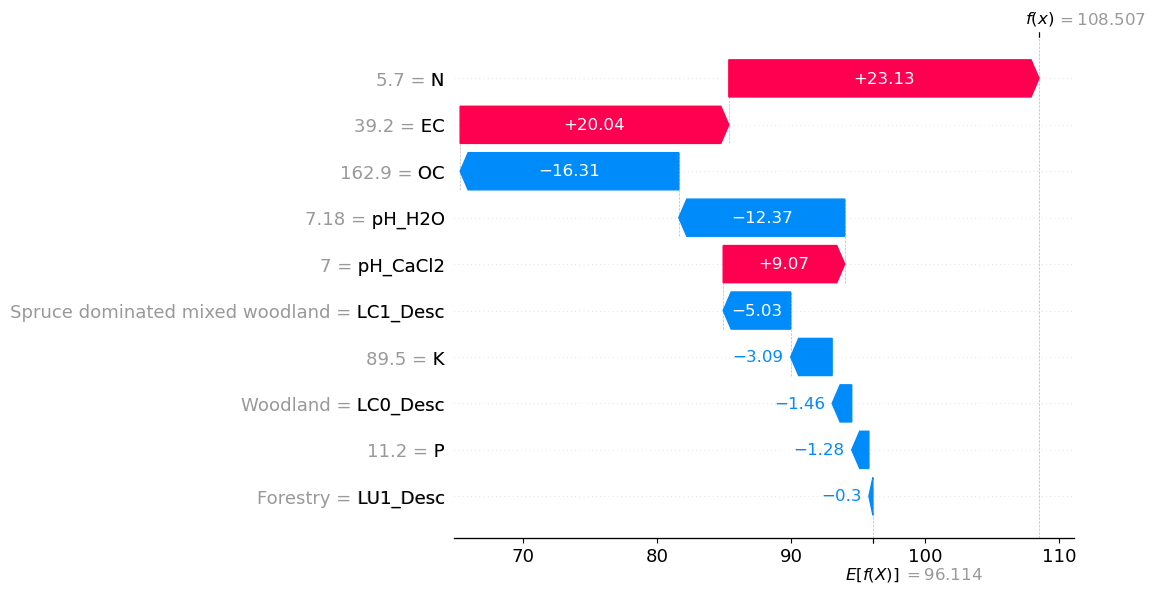

In [132]:
shap.plots.waterfall(shap_values[20,...]) # Medium

## High CaCo3

In [102]:
df[list_X + [target]].iloc[[3879]]

,pH_CaCl2,pH_H2O,EC,OC,P,N,K,LC0_Desc,LC1_Desc,LU1_Desc,CaCO3
3879,7.8,8.35,16.44,21.4,-1.0,1.6,330.5,Woodland,Broadleaved woodland,Forestry,513.0


In [94]:
model.predict(df[list_X])[3879]

430.9308878614067

In [135]:
# shap.plots.force(xgb_explainer.expected_value,shap_values[0,...], feature_names=list_X) # Low CaCO3
shap.plots.force(shap_values[3879,...], feature_names=list_X) # Low CaCO3

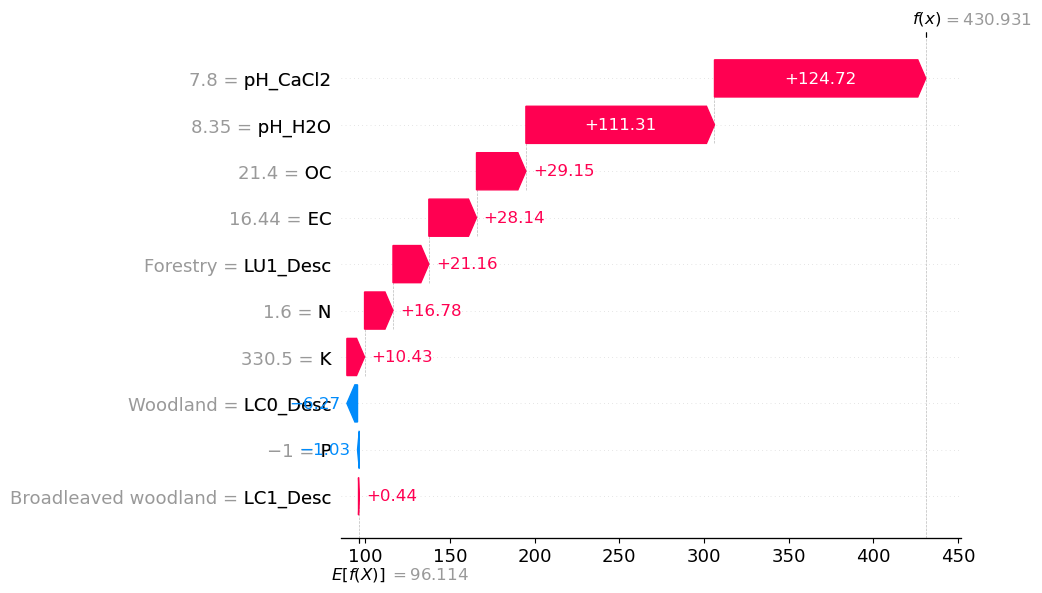

In [137]:
shap.plots.waterfall(shap_values[3879,...]) # Medium